Second version of [2021_2022_Persistence](2021_2022_Persistence.ipynb)

#### Simulation with the prediction block using persistence of the previous instant as prediction method

#### $\hspace{15px}$ $\tilde{X}(k) = X(k-1)$, 
#### $\hspace{15px}$ $\tilde{Y}(k) = Y(k-1)$, 


Maximum voltage rise $vm_{pu}^{max} = 1.0250 - 0.025\% $

---

#### Import Modules 


In [1]:
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
import ipyparallel as ipp
import math as mt
from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf
import joblib

In [2]:
# import psutil
function_folder = '../Modules/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
from oriVariables import (simResult_folder,
                          Δt, 
                          ctrld_HvProd_name,
                          h_start_end, 
                          hm10_start_end, 
                          defAuth_hvBus_vRiseMax, 
                          defAuth_hvBus_vRiseMin, 
                          modules_folder, 
                          valSet_start_M2, 
                          testSet_end_M1, 
                          lowerNet_file_loc, 
                          pd_Δt, 
                          upperNet_file_loc) 

import checker

#### Import Networks


In [3]:
lowerNet=pp.from_pickle(lowerNet_file_loc)
upperNet=pp.from_pickle(upperNet_file_loc)

# Compute the total of BT prod and Load on St Laurent
sum_max_p_mw_StLaurent_prodBT =upperNet.sgen[upperNet.sgen.name.isna()].max_p_mw.sum()
sum_max_p_mw_StLaurent_load = upperNet.load.max_p_mw.sum()

# To use later in functions 
sum_max_main_network = (sum_max_p_mw_StLaurent_prodBT, sum_max_p_mw_StLaurent_load)

#### Import data Cleaned file for network's input

In [4]:
df_data = joblib.load(f'{simResult_folder}StLaurent_cleanedData.pkl')

# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. 
per_index = df_data.index
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object).between_time(*hm10_start_end) ).index.to_period(pd_Δt)
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])


# Put all the data in a unique dataframe
df_data = df_data.loc[per_daylight]

# # Extract only the relavant testing set since the training set covers the first part of the data
df_final = df_data[(df_data.index>=valSet_start_M2) & (df_data.index<=testSet_end_M1)]
per_index = df_final.index
per_index2 = ( pd.Series(index=per_index.to_timestamp(), dtype=object
                           ).between_time(*h_start_end) ).index.to_period(pd_Δt)

df_final_copy = df_final.copy(deep=True)

# Check wether the input dataframe columns are in the expected order
checker.check_networkDataDf_columnsOrder(df_final)


# If df_final is in the expected form we can collect the data as follow
df_cons_total = df_final.iloc[:,[0]]
df_prod_bt_total = df_final.iloc[:,[1]]
df_prodHT = df_final.iloc[:,2:]

#### Data extraction from the network

In [5]:
lowerNet_hv_bus = list(lowerNet.bus.groupby('vn_kv'))[1][1] # Extract HV bus in the network

pp.runpp(lowerNet) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index = list(lowerNet.res_bus.vm_pu[lowerNet.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
lowerNet_hv_activated_bus = [i for i in activated_bus_index 
                               if i in lowerNet_hv_bus.index]


#### Create daylight period mask 

#### Start Parallel engines

In [6]:
n_engines = os.cpu_count() - 1
cluster = ipp.Cluster(n=n_engines) # Create cluster
cluster.start_cluster_sync()       # Start cluster 
rc = cluster.connect_client_sync() # connect client
rc.wait_for_engines(n_engines)     # Wait for engines to be available for all clients
dview = rc[:]                      # Create a direct view of all engine or clients that would
                                   # be used to command each client

Starting 7 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/7 [00:00<?, ?engine/s]

## OPF Persistence Model 

#### Load network

In [7]:
lowerNet=pp.from_pickle(lowerNet_file_loc) # Reload network with new name 

# Add a controllable line to the static generators
lowerNet.sgen['controllable'] = False 

# Set the producer ctrld_HvProd as a controllable load
lowerNet.sgen['controllable'][lowerNet.sgen.name==ctrld_HvProd_name] = True

# Add Missing columns to be able to un an opf 
lowerNet.sgen[['min_p_mw', 'min_q_mvar', 'max_q_mvar']]=0.

# Rename data in bus network because the names do not correspond to the parameters in pandapower 
lowerNet.bus.rename({'max_vw_pu':'max_vm_pu',}, axis=1, inplace=True)

lowerNet.bus.drop(['max_vm', 'min_vm'], axis=1, inplace=True)    # Delete useless parameters
lowerNet_hv_bus = list(lowerNet.bus.groupby('vn_kv'))[1][1]   # Extract HV bus in the network

pp.runpp(lowerNet) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index2 = list(lowerNet.res_bus.vm_pu[lowerNet.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
lowerNet_hv_activated_bus = [i for i in activated_bus_index2 
                               if i in lowerNet_hv_bus.index]

#### Add maximum voltage constraints on the Buses in the network 

In [8]:
vm_mu_max0 = defAuth_hvBus_vRiseMax
vm_mu_max = defAuth_hvBus_vRiseMax - 0.25/100
vm_mu_min = defAuth_hvBus_vRiseMin 

# lowerNet.bus.max_vm_pu[lowerNet.bus.max_vm_pu.notna()] = vm_mu_max
lowerNet.bus.max_vm_pu[lowerNet_hv_activated_bus] = vm_mu_max
lowerNet.bus.min_vm_pu[lowerNet_hv_activated_bus] = vm_mu_min


In [9]:
# get the index of the controlled HV prod in SGEN table
ctrld_hvProd_index = lowerNet.sgen.query('name==@ctrld_HvProd_name').index

# Add negative cost to usability of sgen ctrld_HvProd so its usage can be maximised while respecting the constraints on the network
cost_sgen_ctrld_HvProd = pp.create_poly_cost(lowerNet, ctrld_hvProd_index,'sgen', cp1_eur_per_mw=-1)

lowerNet.poly_cost

,element,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,23,sgen,0.0,-1.0,0.0,0.0,0.0,0.0


#### Send data into local space of each engine

In [10]:
# Clear the localspace of all engines
dview.clear() 

# # Import following modules on the local space of clients or engines
with rc[:].sync_imports():
    import numpy
    import pandapower
    import pandas
    import sys

# Add modules location to Par engines namespace
dview[f'sys.path.append("{modules_folder}")']

with rc[:].sync_imports(): # import from modules_folder
    import oriFunctions

# Share the total number of period in df_prodHT.index among all the created engines
dview.scatter('period_part', per_index)

# Parameters for the persistence model
opf_status = 'Both' 
pred_model = 'Pers'

# Define a dict 
dict_df_sgenLoad = dict({'df_prodHT':df_prodHT, 
                         'df_prod_bt_total':df_prod_bt_total, 
                         'df_cons_total':df_cons_total, 
                         'lowerNet_sgenDf_copy': lowerNet.sgen.copy(deep=True)} )

# Create a dictionnary containing all the varible that will be used by each client or engine
parameters_dict = dict({'lowerNet':lowerNet, 
                        'lowerNet_hv_activated_bus':lowerNet_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'dict_df_sgenLoad':dict_df_sgenLoad,
                        'vm_mu_max':vm_mu_max,
                        'opf_status':opf_status, 
                        'pred_model':pred_model })

dview.push(parameters_dict) # Add all  variables in the parameters_dict 
                            # to  the local space of each client

importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing sys on engine(s)
importing oriFunctions on engine(s)


<AsyncResult(_push): pending>

#### Run Optimal /power flow  in each local engine
**<span style='color:red'> -----------------  BLOC  PF/OPF -------------------  </span>**

In [11]:
%%px 
resulting = [oriFunctions.run_powerflow_at(lowerNet, cur_period+1, lowerNet_hv_activated_bus, sum_max_main_network, 
                                    dict_df_sgenLoad, vm_mu_max, opf_status, pred_model) 
             for cur_period in period_part]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

 <span style='color:red'> **-------------------------------------------------------**  </span>

#### Extract results

In [12]:
# Gather the result of each engine in a single list
results = dview.gather('resulting')
time.sleep(1)

# Extract results
extracted_results = oriFc.extractParRes_asDf(results, df_prodHT)

# Get maximum volatage over the network 
max_vm_pu_df_pers = extracted_results[['max_vm_pu']]

### Reality check

**<span style='color:red'> -------------------  BLOC PROD  ---------------------</span>**

In [13]:
extracted_results.loc[per_index2, [ctrld_HvProd_name]] = (np.minimum(df_prodHT.loc[per_index2, ctrld_HvProd_name],
                                                           extracted_results.loc[per_index2, ctrld_HvProd_name]))

 <span style='color:red'> **-------------------------------------------------------**  </span>

#### Update Values for the dict to use for power flow


In [14]:
hv_prodName = df_final.columns[2:]          # Extract all HV prod names
nonCtrld_HvProd_name= list(set(hv_prodName) # Get the non controllable HV prod names
                           .difference(set([ctrld_HvProd_name]) ) 
                          )

prod_hv_df = pd.concat([df_final.loc[per_index2, nonCtrld_HvProd_name], 
                        extracted_results.loc[per_index2, [ctrld_HvProd_name] ]], axis=1)

dict_df_sgenLoad = dict({'df_prodHT': prod_hv_df, 
                         'df_prod_bt_total':df_prod_bt_total, 
                         'df_cons_total':df_cons_total,
                         'lowerNet_sgenDf_copy': lowerNet.sgen.copy(deep=True)} )

#### Send data into local space of each engine

In [15]:
# # Import following modules on the local space of clients or engines
with rc[:].sync_imports():
    import numpy
    import pandapower
    import pandas
    import sys

# Add modules location to Par engines namespace
dview[f'sys.path.append("{modules_folder}")']

with rc[:].sync_imports(): # import from modules_folder
    import oriFunctions

# Share the total number of period in df_prodHT.index among all the created engines
dview.scatter('period_part', prod_hv_df.index)

# Parameters for the persistence model
opf_status = False 

# Create a dictionnary containing all the varible that will be used by each client or engine
parameters_dict = dict({'lowerNet':lowerNet, 
                        'lowerNet_hv_activated_bus':lowerNet_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'dict_df_sgenLoad':dict_df_sgenLoad,
                        'vm_mu_max':vm_mu_max,
                        'opf_status':opf_status})

dview.push(parameters_dict) # Add all  variables in the parameters_dict 
                            # to  the local space of each client

importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing sys on engine(s)
importing oriFunctions on engine(s)


<AsyncResult(_push): pending>

#### Run power flow in each local engine
**<span style='color:red'> ------------------------ BLOC  PF  -----------------------  </span>**

In [19]:
%%px 
resulting = [oriFunctions.run_powerflow_at(lowerNet, cur_period, lowerNet_hv_activated_bus, sum_max_main_network,
                                    dict_df_sgenLoad, vm_mu_max, opf_status) 
             for cur_period in period_part]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

 <span style='color:red'> **-------------------------------------------------------**  </span>

In [20]:
# Gather the result of each engine in a single list
results_pf_per = dview.gather('resulting')
time.sleep(1)

# Put data in dataframe
max_vm_pu_per_df = pd.DataFrame(data=np.array(results_pf_per)[:,0], 
                                index=np.array(results_pf_per)[:,1], columns=['Pers'],)

#### Plot created Dataframe

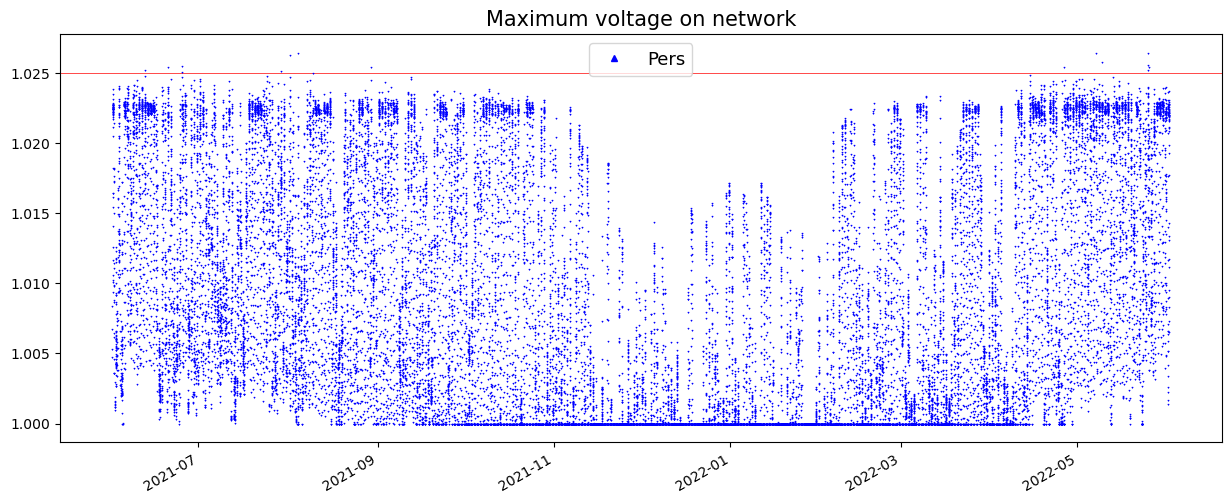

In [21]:
fig, axx = plt.subplots(figsize=(15,6), dpi=100)
plt.axhline(vm_mu_max0,color='r', lw=0.5)

max_vm_pu_per_df.plot(style = ['b^'],markersize=0.5, ax=axx)
plt.legend( fontsize=13, markerscale=10)
plt.title("Maximum voltage on network", fontsize=15);

#### Setting up variables

In [22]:
ctrld_HvProd_df = df_final.loc[per_index2, [ctrld_HvProd_name]]
ctrld_HvProd_pers_df = pd.DataFrame(data=extracted_results.loc[per_index2, ctrld_HvProd_name].values, 
                             index=extracted_results.loc[per_index2].index, 
                             columns=['Pers'] )
# Concat
ctrld_HvProd_concat_df = pd.concat([ctrld_HvProd_df,ctrld_HvProd_pers_df], axis=1)

# Rename
ctrld_HvProd_concat_df.rename(columns=({f'{ctrld_HvProd_name}':'No_Control'}), inplace=True);

#### Plot the Power injected by the controlled HVs in both cases

<AxesSubplot:>

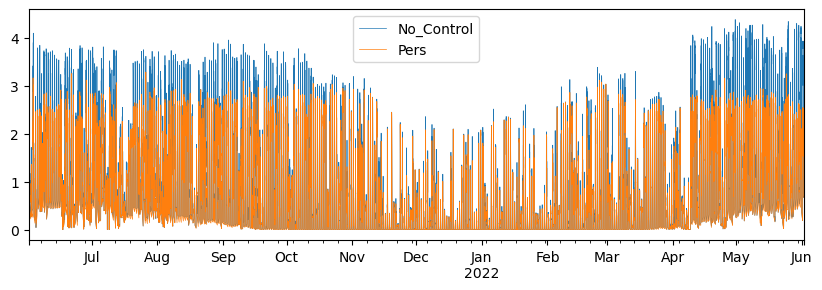

In [23]:
ctrld_HvProd_concat_df.plot(figsize=(10,3), lw=0.5)

#### Compute Energy


In [24]:
# Compute Energy
var_no_control, var_Persistence = ctrld_HvProd_concat_df.sum()*Δt

print(f'{ctrld_HvProd_name} prod,   No Control  : {var_no_control:.2f} MWh')
print(f'{ctrld_HvProd_name} prod, Future known  : {var_Persistence:.2f} MWh |  Perc = {var_Persistence*100/var_no_control:.2f}%')


P0100 prod,   No Control  : 5229.63 MWh
P0100 prod, Future known  : 4234.13 MWh |  Perc = 80.96%
Controller stopped: {'exit_code': 15, 'pid': 23236, 'identifier': 'ipcontroller-1678092880-rppr-22108'}
engine set stopped 1678092881: {'engines': {'0': {'exit_code': 15, 'pid': 15204, 'identifier': '0'}, '1': {'exit_code': 15, 'pid': 24992, 'identifier': '1'}, '3': {'exit_code': 15, 'pid': 16848, 'identifier': '3'}, '5': {'exit_code': 15, 'pid': 19224, 'identifier': '5'}, '4': {'exit_code': 15, 'pid': 21612, 'identifier': '4'}, '2': {'exit_code': 15, 'pid': 3352, 'identifier': '2'}, '6': {'exit_code': 15, 'pid': 15368, 'identifier': '6'}}, 'exit_code': 15}
Stopping engine(s): 1678092881


##### Save Variables
*<span style='color:green'>Run the following cell only one </span>*

In [1]:
var_to_save = dict({f'{ctrld_HvProd_name}_concat_df':ctrld_HvProd_concat_df,
                    'voltage_rise_df':max_vm_pu_per_df, 
                    'Out_blocProd': extracted_results.loc[per_index2]# Where out bloc prod is the result 
                                                        # of the prediction using the persistence model 
                                                        # and the corresponding OPF voltage rise
                   })

joblib.dump(var_to_save,f'{simResult_folder}Persistence2.pkl')
